**References:**

1. https://keras.io/api/applications/
2. https://keras.io/guides/transfer_learning/

In [3]:
!nvidia-smi

Tue Aug 17 11:19:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

P100

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/SVNCKH'
! ls

/content/gdrive/MyDrive/SVNCKH
Database  Feature_extraction_01.ipynb


In [4]:
# import the basic libraries
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Flatten, Reshape, ReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import GlobalAveragePooling2D, Concatenate, Lambda, add
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from glob import glob

**1. Xception**

In [5]:
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [299, 299]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [6]:
# add preprocessing layer to the front of Xception
xception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

83697664/83683744 [==============================] - 0s 0us/step


In [7]:
# don't train existing weights
for layer in xception.layers:
  layer.trainable = False

In [8]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [9]:
# our layers - you can add more if you want
x = Flatten()(xception.output)

In [10]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [11]:
# create a model object
model = Model(inputs=xception.input, outputs=prediction)

In [12]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [13]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (299, 299),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (299, 299),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (299, 299),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [15]:
# fit the model
xception = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 503s 23s/step - loss: 2.7124 - accuracy: 0.6226 - val_loss: 0.2824 - val_accuracy: 0.9333
Epoch 2/30
20/20 [==============================] - 29s 1s/step - loss: 0.1360 - accuracy: 0.9809 - val_loss: 0.0734 - val_accuracy: 0.9852
Epoch 3/30
20/20 [==============================] - 29s 1s/step - loss: 0.0708 - accuracy: 0.9852 - val_loss: 0.0829 - val_accuracy: 0.9852
Epoch 4/30
20/20 [==============================] - 29s 1s/step - loss: 0.0669 - accuracy: 0.9860 - val_loss: 0.1507 - val_accuracy: 0.9778
Epoch 5/30
20/20 [==============================] - 30s 1s/step - loss: 0.0276 - accuracy: 0.9947 - val_loss: 0.1746 - val_accuracy: 0.9741
Epoch 6/30
20/20 [==============================] - 29s 1s/step - loss: 0.0073 - accuracy: 0.9988 - val_loss: 0.1537 - val_accuracy: 0.9852
Epoch 7/30
20/20 [==============================] - 30s 1s/step - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.2642 - val_accuracy: 0.9481
Epoch 8/30
20/20 [

In [16]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.4369
Test accuracy: 0.9667


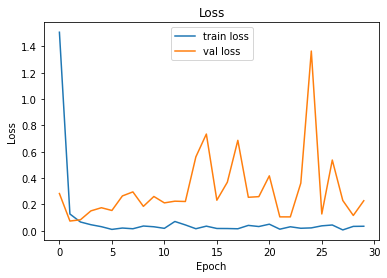

In [17]:
# loss
plt.plot(xception.history['loss'], label='train loss')
plt.plot(xception.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('Xception_loss')

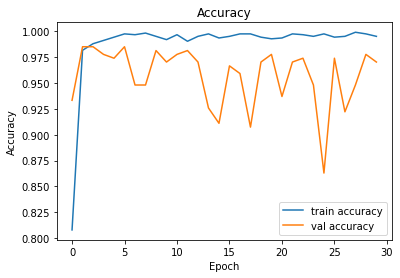

In [18]:
# accuracy
plt.plot(xception.history['accuracy'], label='train accuracy')
plt.plot(xception.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('Xception_accuracy')

**2. VGG16**

In [19]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [20]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [21]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [22]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [23]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [24]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [25]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [26]:
# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [27]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [28]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [29]:
# fit the model
vgg16 = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 41s 1s/step - loss: 1.2771 - accuracy: 0.4971 - val_loss: 0.3691 - val_accuracy: 0.8704
Epoch 2/30
20/20 [==============================] - 17s 828ms/step - loss: 0.2361 - accuracy: 0.9281 - val_loss: 0.2755 - val_accuracy: 0.9000
Epoch 3/30
20/20 [==============================] - 17s 824ms/step - loss: 0.1801 - accuracy: 0.9582 - val_loss: 0.2289 - val_accuracy: 0.9222
Epoch 4/30
20/20 [==============================] - 17s 859ms/step - loss: 0.1225 - accuracy: 0.9728 - val_loss: 0.2234 - val_accuracy: 0.9222
Epoch 5/30
20/20 [==============================] - 18s 888ms/step - loss: 0.0967 - accuracy: 0.9797 - val_loss: 0.2185 - val_accuracy: 0.9222
Epoch 6/30
20/20 [==============================] - 17s 827ms/step - loss: 0.0976 - accuracy: 0.9775 - val_loss: 0.2077 - val_accuracy: 0.9222
Epoch 7/30
20/20 [==============================] - 17s 839ms/step - loss: 0.0930 - accuracy: 0.9761 - val_loss: 0.1577 - val_accuracy: 0.9481
Ep

In [30]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0475
Test accuracy: 0.9815


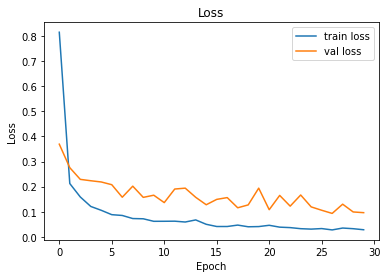

In [31]:
# loss
plt.plot(vgg16.history['loss'], label='train loss')
plt.plot(vgg16.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('VGG16_loss')

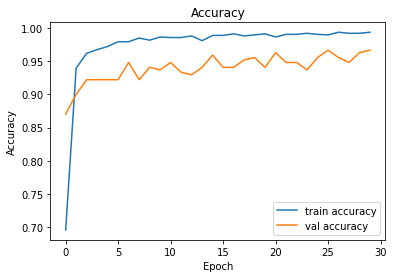

In [32]:
# accuracy
plt.plot(vgg16.history['accuracy'], label='train accuracy')
plt.plot(vgg16.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('VGG16_accuracy')

**3. ResNet50**

In [33]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [34]:
# add preprocessing layer to the front of ResNet
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [35]:
# don't train existing weights
for layer in resnet.layers:
  layer.trainable = False

In [36]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [38]:
# our layers - you can add more if you want
x = layers.Flatten()(resnet.output)

In [40]:
#x = Dense(3, activation='relu')(x)
prediction = layers.Dense(len(folders), activation='softmax')(x)

In [41]:
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [42]:
# view the structure of the model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 24,189,830
Trainable params: 602,118
Non-trainable params: 23,587,712
__________________________________________________________________________________________________


In [43]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [44]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [45]:
# fit the model
resnet = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 21s 852ms/step - loss: 7.0609 - accuracy: 0.1955 - val_loss: 4.2871 - val_accuracy: 0.3333
Epoch 2/30
20/20 [==============================] - 16s 805ms/step - loss: 3.5928 - accuracy: 0.2533 - val_loss: 1.7328 - val_accuracy: 0.2630
Epoch 3/30
20/20 [==============================] - 16s 834ms/step - loss: 1.7201 - accuracy: 0.3915 - val_loss: 1.8178 - val_accuracy: 0.4222
Epoch 4/30
20/20 [==============================] - 15s 767ms/step - loss: 1.4348 - accuracy: 0.4724 - val_loss: 1.2901 - val_accuracy: 0.4111
Epoch 5/30
20/20 [==============================] - 15s 766ms/step - loss: 1.2224 - accuracy: 0.5340 - val_loss: 1.1183 - val_accuracy: 0.5370
Epoch 6/30
20/20 [==============================] - 16s 792ms/step - loss: 1.1784 - accuracy: 0.5356 - val_loss: 1.4284 - val_accuracy: 0.4556
Epoch 7/30
20/20 [==============================] - 17s 826ms/step - loss: 1.1780 - accuracy: 0.5202 - val_loss: 1.1386 - val_accuracy: 0.5222

In [46]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.8226
Test accuracy: 0.6333


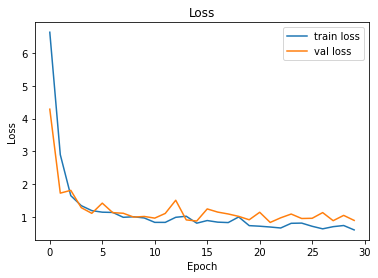

In [47]:
# loss
plt.plot(resnet.history['loss'], label='train loss')
plt.plot(resnet.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('ResNet50_loss')

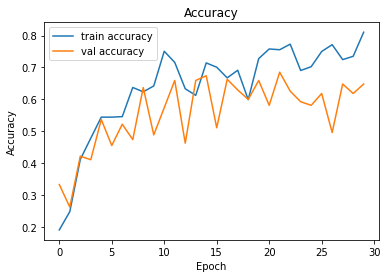

In [48]:
# accuracy
plt.plot(resnet.history['accuracy'], label='train accuracy')
plt.plot(resnet.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('ResNet50_accuracy')

**4. InceptionV3**

In [49]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [299, 299]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [50]:
# add preprocessing layer to the front of Inception
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 0s 0us/step


In [51]:
# don't train existing weights
for layer in inception.layers:
  layer.trainable = False

In [52]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [53]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [54]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [55]:
# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [56]:
# view the structure of the model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 149, 149, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

In [57]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [58]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (299, 299),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (299, 299),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (299, 299),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [59]:
# fit the model
inception = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 49s 2s/step - loss: 5.1456 - accuracy: 0.5761 - val_loss: 1.1413 - val_accuracy: 0.8926
Epoch 2/30
20/20 [==============================] - 26s 1s/step - loss: 0.4715 - accuracy: 0.9483 - val_loss: 1.2623 - val_accuracy: 0.8741
Epoch 3/30
20/20 [==============================] - 24s 1s/step - loss: 0.0230 - accuracy: 0.9935 - val_loss: 0.6127 - val_accuracy: 0.9444
Epoch 4/30
20/20 [==============================] - 25s 1s/step - loss: 0.0148 - accuracy: 0.9959 - val_loss: 0.3385 - val_accuracy: 0.9519
Epoch 5/30
20/20 [==============================] - 25s 1s/step - loss: 0.0278 - accuracy: 0.9956 - val_loss: 0.6273 - val_accuracy: 0.9407
Epoch 6/30
20/20 [==============================] - 24s 1s/step - loss: 0.0168 - accuracy: 0.9944 - val_loss: 0.5641 - val_accuracy: 0.9444
Epoch 7/30
20/20 [==============================] - 26s 1s/step - loss: 0.0191 - accuracy: 0.9964 - val_loss: 1.0935 - val_accuracy: 0.9185
Epoch 8/30
20/20 [==

In [60]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.3642
Test accuracy: 0.9778


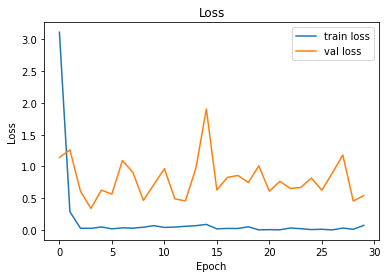

In [61]:
# loss
plt.plot(inception.history['loss'], label='train loss')
plt.plot(inception.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('InceptionV3_loss')

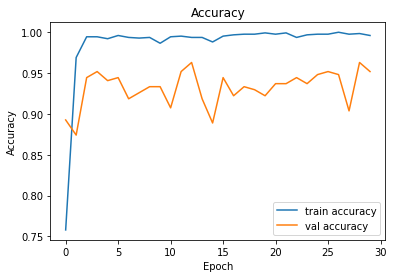

In [62]:
# accuracy
plt.plot(inception.history['accuracy'], label='train accuracy')
plt.plot(inception.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('InceptionV3_accuracy')

**5. MobileNet**

In [63]:
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [64]:
# add preprocessing layer to the front of MobileNet
mobilenet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [65]:
# don't train existing weights
for layer in mobilenet.layers:
  layer.trainable = False

In [66]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [67]:
# our layers - you can add more if you want
x = Flatten()(mobilenet.output)

In [68]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [69]:
# create a model object
model = Model(inputs=mobilenet.input, outputs=prediction)

In [70]:
# view the structure of the model
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [71]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [72]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [73]:
# fit the model
mobilenet = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 21s 801ms/step - loss: 1.7604 - accuracy: 0.6532 - val_loss: 0.1885 - val_accuracy: 0.9519
Epoch 2/30
20/20 [==============================] - 15s 753ms/step - loss: 0.0165 - accuracy: 0.9950 - val_loss: 0.0608 - val_accuracy: 0.9778
Epoch 3/30
20/20 [==============================] - 15s 755ms/step - loss: 0.0312 - accuracy: 0.9921 - val_loss: 0.0234 - val_accuracy: 0.9926
Epoch 4/30
20/20 [==============================] - 14s 714ms/step - loss: 0.0133 - accuracy: 0.9971 - val_loss: 0.0469 - val_accuracy: 0.9852
Epoch 5/30
20/20 [==============================] - 14s 701ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.0724 - val_accuracy: 0.9778
Epoch 6/30
20/20 [==============================] - 14s 712ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0334 - val_accuracy: 0.9926
Epoch 7/30
20/20 [==============================] - 15s 756ms/step - loss: 0.0133 - accuracy: 0.9966 - val_loss: 0.1740 - val_accuracy: 0.9593

In [74]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0213
Test accuracy: 0.9926


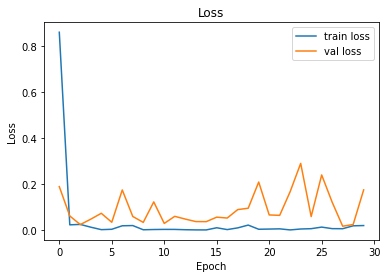

In [75]:
# loss
plt.plot(mobilenet.history['loss'], label='train loss')
plt.plot(mobilenet.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('MobileNet_loss')

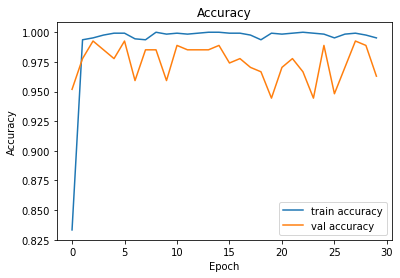

In [76]:
# accuracy
plt.plot(mobilenet.history['accuracy'], label='train accuracy')
plt.plot(mobilenet.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('MobileNet_accuracy')

**6. DenseNet121**

In [77]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [78]:
# add preprocessing layer to the front of DenseNet
densenet = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

29097984/29084464 [==============================] - 0s 0us/step


In [79]:
# don't train existing weights
for layer in densenet.layers:
  layer.trainable = False

In [80]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [81]:
# our layers - you can add more if you want
x = Flatten()(densenet.output)

In [82]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [83]:
# create a model object
model = Model(inputs=densenet.input, outputs=prediction)

In [84]:
# view the structure of the model
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [85]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [86]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [87]:
# fit the model
densenet = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 47s 1s/step - loss: 0.9070 - accuracy: 0.7316 - val_loss: 0.0542 - val_accuracy: 0.9741
Epoch 2/30
20/20 [==============================] - 15s 757ms/step - loss: 0.0737 - accuracy: 0.9824 - val_loss: 0.0560 - val_accuracy: 0.9741
Epoch 3/30
20/20 [==============================] - 16s 815ms/step - loss: 0.0142 - accuracy: 0.9960 - val_loss: 0.0414 - val_accuracy: 0.9815
Epoch 4/30
20/20 [==============================] - 16s 818ms/step - loss: 0.0454 - accuracy: 0.9891 - val_loss: 0.0776 - val_accuracy: 0.9778
Epoch 5/30
20/20 [==============================] - 15s 767ms/step - loss: 0.0079 - accuracy: 0.9984 - val_loss: 0.0431 - val_accuracy: 0.9889
Epoch 6/30
20/20 [==============================] - 15s 762ms/step - loss: 0.0076 - accuracy: 0.9964 - val_loss: 0.0418 - val_accuracy: 0.9889
Epoch 7/30
20/20 [==============================] - 16s 804ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.0726 - val_accuracy: 0.9852
Ep

In [88]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0358
Test accuracy: 0.9963


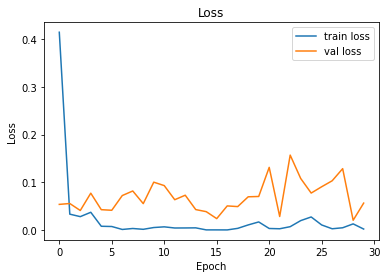

In [89]:
# loss
plt.plot(densenet.history['loss'], label='train loss')
plt.plot(densenet.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('DenseNet_loss')

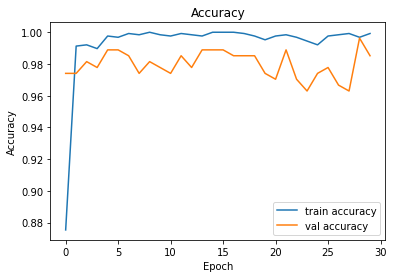

In [90]:
# accuracy
plt.plot(densenet.history['accuracy'], label='train accuracy')
plt.plot(densenet.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('DenseNet_accuracy')

**7. NASNetMobile**

In [91]:
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [92]:
# add preprocessing layer to the front of NASNetMobile
nasnet = NASNetMobile(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

20004864/19993432 [==============================] - 0s 0us/step


In [93]:
# don't train existing weights
for layer in nasnet.layers:
  layer.trainable = False

In [94]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [95]:
# our layers - you can add more if you want
x = Flatten()(nasnet.output)

In [96]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [97]:
# create a model object
model = Model(inputs=nasnet.input, outputs=prediction)

In [98]:
# view the structure of the model
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [99]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [100]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [101]:
# fit the model
nasnet = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 63s 2s/step - loss: 1.8491 - accuracy: 0.6250 - val_loss: 0.2370 - val_accuracy: 0.9370
Epoch 2/30
20/20 [==============================] - 15s 734ms/step - loss: 0.1489 - accuracy: 0.9661 - val_loss: 0.1573 - val_accuracy: 0.9593
Epoch 3/30
20/20 [==============================] - 15s 740ms/step - loss: 0.0876 - accuracy: 0.9853 - val_loss: 0.2640 - val_accuracy: 0.9593
Epoch 4/30
20/20 [==============================] - 16s 807ms/step - loss: 0.0598 - accuracy: 0.9855 - val_loss: 0.1924 - val_accuracy: 0.9593
Epoch 5/30
20/20 [==============================] - 16s 782ms/step - loss: 0.0592 - accuracy: 0.9897 - val_loss: 0.2888 - val_accuracy: 0.9444
Epoch 6/30
20/20 [==============================] - 15s 741ms/step - loss: 0.0271 - accuracy: 0.9916 - val_loss: 0.3181 - val_accuracy: 0.9519
Epoch 7/30
20/20 [==============================] - 15s 736ms/step - loss: 0.0234 - accuracy: 0.9940 - val_loss: 0.1730 - val_accuracy: 0.9741
Ep

In [102]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.2215
Test accuracy: 0.9741


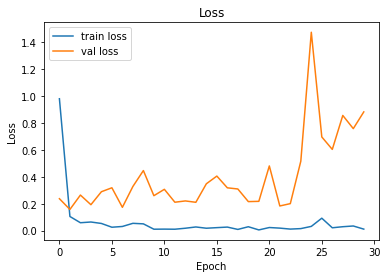

In [103]:
# loss
plt.plot(nasnet.history['loss'], label='train loss')
plt.plot(nasnet.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('NASNetMobile_loss')

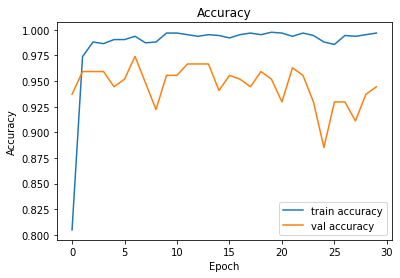

In [104]:
# accuracy
plt.plot(nasnet.history['accuracy'], label='train accuracy')
plt.plot(nasnet.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('NASNetMobile_accuracy')

**8. EfficientNet**

In [105]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 4.8 MB/s 


In [108]:
import efficientnet.keras as efn
from tensorflow.keras.applications import EfficientNetB0

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [109]:
# add preprocessing layer to the front of EfficientNetB0
efficientnet = EfficientNetB0(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

16711680/16705208 [==============================] - 0s 0us/step


In [110]:
# don't train existing weights
for layer in efficientnet.layers:
  layer.trainable = False

In [111]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [113]:
# our layers - you can add more if you want
x = layers.Flatten()(efficientnet.output)

In [115]:
#x = Dense(3, activation='relu')(x)
prediction = layers.Dense(len(folders), activation='softmax')(x)

In [116]:
# create a model object
model = Model(inputs=efficientnet.input, outputs=prediction)

In [117]:
# view the structure of the model
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 4,425,897
Trainable params: 376,326
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [118]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [119]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [120]:
# fit the model
efficientnet = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 23s 860ms/step - loss: 10.0292 - accuracy: 0.1755 - val_loss: 6.0000 - val_accuracy: 0.1667
Epoch 2/30
20/20 [==============================] - 15s 749ms/step - loss: 4.8443 - accuracy: 0.1478 - val_loss: 2.9463 - val_accuracy: 0.1667
Epoch 3/30
20/20 [==============================] - 15s 732ms/step - loss: 2.5637 - accuracy: 0.1870 - val_loss: 2.0650 - val_accuracy: 0.1667
Epoch 4/30
20/20 [==============================] - 15s 739ms/step - loss: 2.1260 - accuracy: 0.1765 - val_loss: 1.8885 - val_accuracy: 0.1667
Epoch 5/30
20/20 [==============================] - 16s 802ms/step - loss: 2.0306 - accuracy: 0.1987 - val_loss: 2.3935 - val_accuracy: 0.1667
Epoch 6/30
20/20 [==============================] - 15s 760ms/step - loss: 2.2287 - accuracy: 0.1789 - val_loss: 2.4255 - val_accuracy: 0.1667
Epoch 7/30
20/20 [==============================] - 15s 734ms/step - loss: 2.1143 - accuracy: 0.1834 - val_loss: 1.8944 - val_accuracy: 0.166

In [121]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 1.8875
Test accuracy: 0.1667


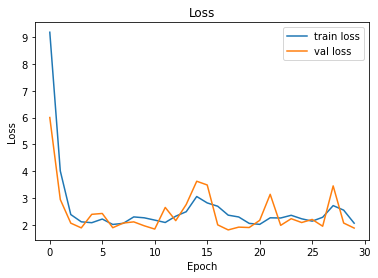

In [122]:
# loss
plt.plot(efficientnet.history['loss'], label='train loss')
plt.plot(efficientnet.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('EfficientNetB0_loss')

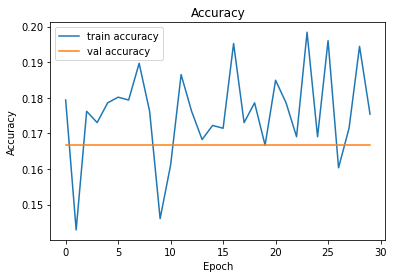

In [123]:
# accuracy
plt.plot(efficientnet.history['accuracy'], label='train accuracy')
plt.plot(efficientnet.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('EfficientNetB0_accuracy')

**The accuracy comparison charts:**

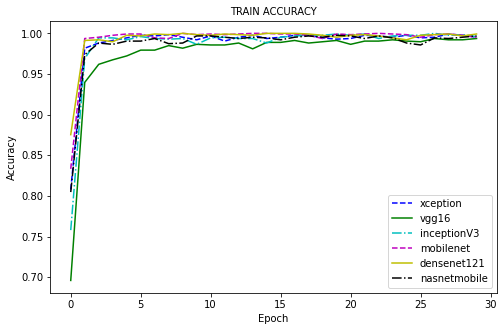

In [124]:
# train accuracy
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(xception.history['accuracy'], '--b', label='xception')
plt.plot(vgg16.history['accuracy'], '-g', label='vgg16')
#plt.plot(resnet.history['accuracy'], '-.r', label='resnet50')
plt.plot(inception.history['accuracy'], '-.c', label='inceptionV3')
plt.plot(mobilenet.history['accuracy'], '--m', label='mobilenet')
plt.plot(densenet.history['accuracy'], '-y', label='densenet121')
plt.plot(nasnet.history['accuracy'], '-.k', label='nasnetmobile')
#plt.plot(efficientnet.history['accuracy'], '--r', label='efficientnetB0')
plt.title(label = 'TRAIN ACCURACY', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('train_accuracy_01')

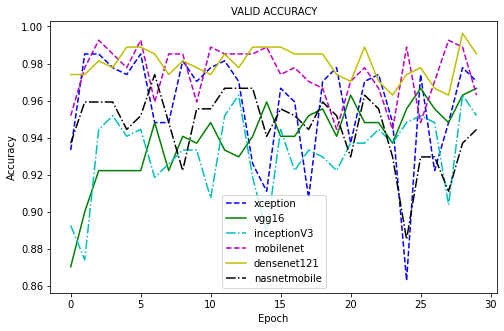

In [125]:
# valid accuracy
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(xception.history['val_accuracy'], '--b', label='xception')
plt.plot(vgg16.history['val_accuracy'], '-g', label='vgg16')
#plt.plot(resnet.history['val_accuracy'], '-.r', label='resnet50')
plt.plot(inception.history['val_accuracy'], '-.c', label='inceptionV3')
plt.plot(mobilenet.history['val_accuracy'], '--m', label='mobilenet')
plt.plot(densenet.history['val_accuracy'], '-y', label='densenet121')
plt.plot(nasnet.history['val_accuracy'], '-.k', label='nasnetmobile')
#plt.plot(efficientnet.history['val_accuracy'], '--r', label='efficientnetB0')
plt.title(label = 'VALID ACCURACY', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('valid_accuracy_01')

**The loss comparison charts:**

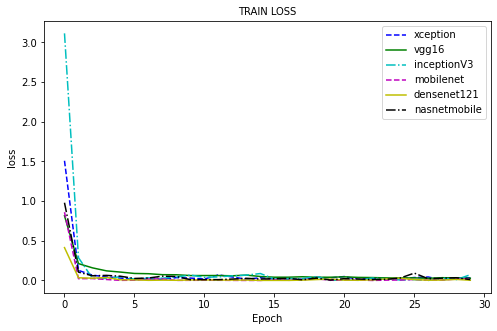

In [126]:
# train loss
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(xception.history['loss'], '--b', label='xception')
plt.plot(vgg16.history['loss'], '-g', label='vgg16')
#plt.plot(resnet.history['loss'], '-.r', label='resnet50')
plt.plot(inception.history['loss'], '-.c', label='inceptionV3')
plt.plot(mobilenet.history['loss'], '--m', label='mobilenet')
plt.plot(densenet.history['loss'], '-y', label='densenet121')
plt.plot(nasnet.history['loss'], '-.k', label='nasnetmobile')
#plt.plot(efficientnet.history['loss'], '--r', label='efficientnetB0')
plt.title(label = 'TRAIN LOSS', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
fig.savefig('train_loss_01')

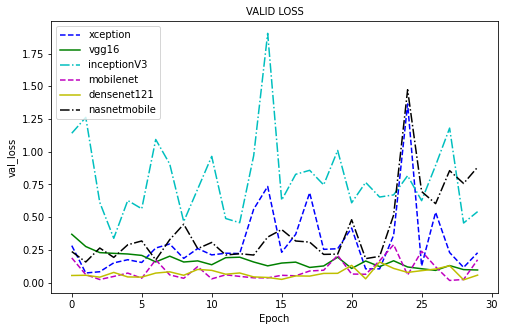

In [127]:
# valid loss
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(xception.history['val_loss'], '--b', label='xception')
plt.plot(vgg16.history['val_loss'], '-g', label='vgg16')
#plt.plot(resnet.history['val_loss'], '-.r', label='resnet50')
plt.plot(inception.history['val_loss'], '-.c', label='inceptionV3')
plt.plot(mobilenet.history['val_loss'], '--m', label='mobilenet')
plt.plot(densenet.history['val_loss'], '-y', label='densenet121')
plt.plot(nasnet.history['val_loss'], '-.k', label='nasnetmobile')
#plt.plot(efficientnet.history['val_loss'], '--r', label='efficientnetB0')
plt.title(label = 'VALID LOSS', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('val_loss')
plt.legend()
plt.show()
fig.savefig('valid_loss_01')